In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import time
import heatmap_setup as hm
import numpy as np

from SES_setup import *
from utils import *
from style import *

SES_setup loaded globally


# Figures 1.13 (left) and (right)

In [2]:
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{physics} ')
colours = ['#1E90FF', '#3CB371', '#FFA500', '#FF0000']

In [35]:
alpha = 100.
w0 = 200.
shift_1 = pi*alpha/2
kappa = np.sqrt(np.pi * alpha * w0 / 2.)
print(kappa)
Gamma = 100
gamma = Gamma / (2. * np.pi * w0) 
shift_2 = - (kappa**2)/w0
print(shift_1, shift_2, pi*gamma/2)

phonons = np.array([6,12,18])*1e-3*ev_to_inv_cm

177.2453850905516
157.07963267948966 -157.07963267948963 0.125


In [3]:
def dark_bright_displacements(PARAMS):
    
    disp_2 = sqrt(pi*PARAMS['alpha_2']/(2*PARAMS['w0_2']))
    eta = sqrt(PARAMS['bias']**2+4*PARAMS['V']**2)
    coeff_m = (eta-PARAMS['bias'])/(2*eta)
    coeff_p = (eta+PARAMS['bias'])/(2*eta)
    
    # dark 1&2, bright 1&2
    return [disp_1*coeff_m, disp_2*coeff_p], [disp_1*coeff_p, disp_2*coeff_m]

def polaron_eigenstates(PARAMS_):
    disp_1 = sqrt(pi*PARAMS_['alpha_1']/(2*PARAMS_['w0_1']))
    kappa_1 =  np.sqrt(np.pi * PARAMS_['alpha_1'] * PARAMS_['w0_1'] / 2.)
    disp_2 = sqrt(pi*PARAMS_['alpha_2']/(2*PARAMS_['w0_2']))
    kappa_2 =  np.sqrt(np.pi * PARAMS_['alpha_2'] * PARAMS_['w0_2'] / 2.)
    B1 = np.exp(-(disp_1**2)/2)  # Coth(beta_f(PARAMS['T_1'])*PARAMS['w0_1']/2)*
    B2 = np.exp(-(disp_2**2)/2) # Coth(beta_f(PARAMS['T_2'])*PARAMS['w0_2']/2)*
    #B1, B2 = coherent_overlaps_plain(PARAMS)
    
    w_1, w_2 = PARAMS_['w_1'], PARAMS_['w_1']
    shift_1, shift_2 = 0,0 #pi*PARAMS['alpha_1']/2, pi*PARAMS['alpha_2']/2
    V = PARAMS_['V']
    bias = PARAMS_['bias'] + shift_1 - shift_2
    eta = sqrt(PARAMS_['bias']**2+4*PARAMS_['V']**2)
    av_site_energy = (w_1+shift_1+w_2+shift_2)/2
    
    eta_polaron = sqrt(PARAMS_['bias']**2+4*B1*B2*(PARAMS_['V']**2))
    disp_dark, disp_bright = dark_bright_displacements(PARAMS_)
    second_order = ((2*V*bias*B1*B2/eta)**2)/eta
    #print(second_order)
    dark_energy = av_site_energy - (eta_polaron**2)/(2*eta) - second_order
    #dark_energy += PARAMS['w0_1']*(disp_dark[0]**2)+PARAMS['w0_2']*(disp_dark[1]**2)
    
    bright_energy = av_site_energy + (eta_polaron**2)/(2*eta) + second_order
    #bright_energy += PARAMS['w0_1']*(disp_bright[0]**2)+(PARAMS['w0_2']**2)*(disp_bright[1]**2)
    eta_P = (eta_polaron**2)/eta
    v_p = qt.Qobj(np.array([0., np.sqrt(eta_P+bias), np.sqrt(eta_P-bias)]))/np.sqrt(2*eta_P)
    v_m = qt.Qobj(np.array([0., np.sqrt(eta_P-bias), -np.sqrt(eta_P+bias)]))/np.sqrt(2*eta_P)
    
    return [dark_energy, bright_energy], [v_m, v_p], eta_polaron



In [4]:



def polaron_coherence(PARAMS):
    energies, states, eta = polaron_eigenstates(PARAMS)
    return states[0]*states[1].dag()

def calculate_polaron_coherence(rho_list, phonons, PARAMS, wc=False):
    pol_coh = []
    for alpha, rho in zip( phonons, rho_list):
        PARAMS.update({'alpha_1' : alpha, 'alpha_2' : alpha})
        I = enr_identity([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
        if wc:
            polaron_coherence_op = polaron_coherence(PARAMS)
        else:
            polaron_coherence_op = tensor(polaron_coherence(PARAMS), I)
        pol_coh.append((polaron_coherence_op*rho).tr())
    return np.array(pol_coh)

def calculate_polaron_coherence_numerical(rho_list, phonons, PARAMS, wc=False):
    
    pol_coh = []
    for alpha, rho in zip( phonons, rho_list):
        PARAMS.update({'alpha_1' : alpha, 'alpha_2' : alpha})
        H, phonon_operators, A_EM, PARAMS = get_H(PARAMS)
        energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
        if wc:
            raise ValueError("NO WC functionality yet")
        else:
            bright_ket = (sum(states_dict['bright'])/sum(states_dict['bright']).norm())
            dark_ket = (sum(states_dict['dark'])/sum(states_dict['dark']).norm())
            polaron_coherence_op = bright_ket*dark_ket.dag()
        pol_coh.append((polaron_coherence_op*rho).tr())
    return np.array(pol_coh)

def calculate_expval(rho_list, op_list, obs='OO'):
    return np.array([(op_list[i][obs]*rho).tr() for i, rho in enumerate(rho_list)])

In [5]:
def calculate_coherence_4_theories(PARAMS, num, threshold=0.):
    phonons = np.linspace(0.5, 20e-3*ev_to_inv_cm, 15)
    
    ti =time.time()
    rho_add = []
    rho_nonadd = []
    rho_sec = []
    rho_wc = []
    
    op_list = []
    
    for j, alpha in enumerate(phonons):
        PARAMS.update({'alpha_1':alpha, 'alpha_2': alpha})
        #energies, states = exciton_states(PARAMS)
        H, L, PARAMS = get_H_and_L_add_and_sec(PARAMS,silent=True, threshold=0.)
        H_wc, L_ns, L_s = get_H_and_L_wc(H[0], PARAMS)
        rho_add.append(steadystate(H[1], [L['add']]))
        rho_nonadd.append(steadystate(H[1], [L['nonadd']]))
        rho_sec.append(steadystate(H[1], [L['sec']]))
        rho_wc.append(steadystate(H[0], [L_ns])) # shift in wc LVN
        op_list.append(make_expectation_operators(PARAMS))
        if j in [1,10,20,30,40,49]:
            print(alpha)
        #print ss.diag()
    data_dict = {}
    filename = 'DATA/coherence/four_theories_{}'.format(num)
    PARAM_names = ['rho_nonadd', 'rho_add', 'rho_sec',
                   'rho_wc', 'op_list', 'phonons', 'PARAMS']
    scope = locals() # Lets eval below use local variables, not global
    data_dict.update(dict((name, eval(name, scope)) for name in PARAM_names))
    print("Calculation took {} seconds".format(time.time()-ti))
    try:
        save_obj(data_dict, filename)
        print( "Filename: "+filename)
    except Exception as e:
        print("Could not save file because: {}".format(e))
    return data_dict


def calculate_bias_dependence_CC(phonons, PARAMS, num, threshold=0., num_biases=60):
    
    biases = np.linspace(0., 60e-3*ev_to_inv_cm, num_biases)
    ti =time.time()
    rho_add_list = []
    rho_nonadd_list = []
    op_list = []
    
    for alpha in phonons:
        PARAMS.update({'alpha_1':alpha, 'alpha_2': alpha})
        rho_nonadd = []
        rho_add = []
        opss = []
        for j, bias in enumerate(biases):
            #PARAMS = get_converged_N(PARAMS, err_threshold=5., min_N=3,max_N=11, silent=True, exc_diff_N=False)
            PARAMS = PARAMS_update_bias(PARAMS_init=PARAMS, bias_value=bias)
            
            H, L, PARAMS = get_H_and_L(PARAMS,silent=True, threshold=0.)
            rho_nonadd.append(steadystate(H[1], [L['nonadd']]))
            rho_add.append(steadystate(H[1], [L['add']]))
            opss.append(make_expectation_operators(PARAMS))
            if j in [1,10,20,30,40,49]:
                print(alpha)
            #print ss.diag()
        rho_nonadd_list.append(rho_nonadd)
        rho_add_list.append(rho_add)
        op_list.append(opss)
    data_dict = {}
    filename = 'DATA/coherence/bias_{}'.format(num)
    PARAM_names = ['rho_nonadd_list', 'rho_add_list', 'biases',
                    'op_list', 'phonons', 'PARAMS']
    scope = locals() # Lets eval below use local variables, not global
    data_dict.update(dict((name, eval(name, scope)) for name in PARAM_names))
    print("Calculation took {} seconds".format(time.time()-ti))
    try:
        save_obj(data_dict, filename)
        print( "Filename: "+filename)
    except Exception as e:
        print("Could not save file because: {}".format(e))
    return data_dict



def calculate_bias_dependence(phonons, PARAMS, num, threshold=0., num_biases=60):
    
    biases = np.linspace(0., 60e-3*ev_to_inv_cm, num_biases)
    ti =time.time()
    rho_add_list = []
    rho_nonadd_list = []
    rho_wc_list = []
    op_list = []
    
    for alpha in phonons:
        PARAMS.update({'alpha_1':alpha, 'alpha_2': alpha})
        rho_nonadd = []
        rho_add = []
        rho_wc = []
        opss = []
        for j, bias in enumerate(biases):
            #PARAMS = get_converged_N(PARAMS, err_threshold=5., min_N=3,max_N=11, silent=True, exc_diff_N=False)
            PARAMS = PARAMS_update_bias(PARAMS_init=PARAMS, bias_value=bias)
            
            H, L, PARAMS = get_H_and_L(PARAMS,silent=True, threshold=0.)
            H_wc, L_ns, L_s = get_H_and_L_wc(H[0], PARAMS)
            rho_nonadd.append(steadystate(H[1], [L['nonadd']]))
            rho_add.append(steadystate(H[1], [L['add']]))
            rho_wc.append(steadystate(H[0], [L_ns])) # shift in wc LVN
            opss.append(make_expectation_operators(PARAMS))
            if j in [1,10,20,30,40,49]:
                print(alpha)
            #print ss.diag()
        rho_nonadd_list.append(rho_nonadd)
        rho_add_list.append(rho_add)
        rho_wc_list.append(rho_wc)
        op_list.append(opss)
    data_dict = {}
    filename = 'DATA/coherence/bias_{}'.format(num)
    PARAM_names = ['rho_nonadd_list', 'rho_add_list', 'rho_wc_list', 'biases',
                    'op_list', 'phonons', 'PARAMS']
    scope = locals() # Lets eval below use local variables, not global
    data_dict.update(dict((name, eval(name, scope)) for name in PARAM_names))
    print("Calculation took {} seconds".format(time.time()-ti))
    try:
        save_obj(data_dict, filename)
        print( "Filename: "+filename)
    except Exception as e:
        print("Could not save file because: {}".format(e))
    return data_dict


In [6]:
def plot_all_four_theories_dark(data_dict, figname='nothing'):
    phonons = data_dict['phonons']
    wc_ops = [make_expectation_operators(data_dict['PARAMS'], 
                                         weak_coupling=True)]*len(data_dict['phonons'])
    dat_nonadd = np.abs(calculate_expval(data_dict['rho_nonadd'], 
                                                           data_dict['op_list'], 
                                                           obs='dark'))
    dat_add = np.abs(calculate_expval(data_dict['rho_add'], 
                                                           data_dict['op_list'], 
                                                           obs='dark'))
    print(dat_nonadd[-1], dat_add[-1], 100*(dat_add[-1]-dat_nonadd[-1])/dat_add[-1])
    plt.plot(phonons, dat_nonadd, label=r"$\dyad{+}{-}$", color=colours[1])
    plt.plot(phonons, dat_add, color=colours[1], ls='dashed')
    
    #dat = np.abs(calculate_polaron_coherence_numerical(data_dict['rho_nonadd'], 
    #                                                       phonons, data_dict['PARAMS']))
    #plt.plot(phonons, dat, label=r"$\dyad{\psi_+}{\psi_-}$", color=colours[0])
    #plt.plot(phonons, np.abs(calculate_polaron_coherence_numerical(data_dict['rho_add'], 
    #                                                       phonons, data_dict['PARAMS'])), 
    #                                                     color=colours[0], ls='dashed')
    plt.subplots_adjust(left=0.14, bottom=0.2, right=0.95, top=0.95, wspace=0.25, hspace=0.08)
    #plt.legend()
    plt.xlim(phonons[0], phonons[-1])
    plt.xlabel(r'$\alpha_1, \alpha_2$ (meV)')
    plt.ylabel(r'$\rho_{-}^{ss}$')
    name= 'PLOTS/'+figname+'.pdf'
    plt.savefig(name)
    print(name)

In [37]:
20e-3*8000

160.0

In [7]:
def plot_all_four_theories(data_dict, figname='nothing'):
    phonons = 1000*data_dict['phonons']/ev_to_inv_cm
    wc_ops = [make_expectation_operators(data_dict['PARAMS'], 
                                         weak_coupling=True)]*len(data_dict['phonons'])
    
    plt.plot(phonons, np.abs(calculate_expval(data_dict['rho_nonadd'], 
                                                           data_dict['op_list'], 
                                                           obs='eig_x')), label=r"$\dyad{+}{-}$", color=colours[1])
    plt.plot(phonons, np.abs(calculate_expval(data_dict['rho_add'], 
                                                           data_dict['op_list'], 
                                                           obs='eig_x')), color=colours[1], ls='dashed')
    
    dat = np.abs(calculate_polaron_coherence_numerical(data_dict['rho_nonadd'], 
                                                           phonons, data_dict['PARAMS']))
    plt.plot(phonons, dat, label=r"$\dyad{\psi_+}{\psi_-}$", color=colours[0])
    plt.plot(phonons, np.abs(calculate_polaron_coherence_numerical(data_dict['rho_add'], 
                                                           phonons, data_dict['PARAMS'])), 
                                                         color=colours[0], ls='dashed')
    plt.subplots_adjust(left=0.14, bottom=0.2, right=0.95, top=0.95, wspace=0.25, hspace=0.08)
    plt.legend()
    plt.xlim(phonons[0], phonons[-1])
    plt.xlabel(r'$\alpha_1, \alpha_2$ (meV)')
    #plt.ylabel(r'$\rho_{+\!-}^{ss}$')
    name= 'PLOTS/'+figname+'.pdf'
    plt.savefig(name)
    print(name)

0.09612264252459611 0.09764371331623964 1.5577764711970972
PLOTS/PAPER/four_theories_UD_dark.pdf


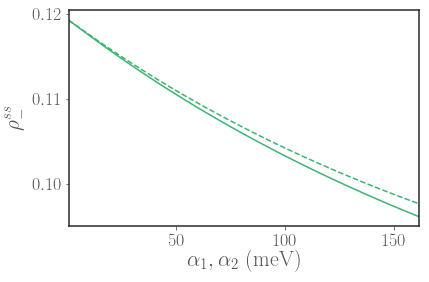

In [7]:

dd_4th = load_obj("DATA/coherence/four_theories_1")
#plot_all_four_theories(dd_4th, figname='PAPER/four_theories_UD')
plot_all_four_theories_dark(dd_4th, figname='PAPER/four_theories_UD_dark')

In [22]:
# OD
N=5
T_ph = 300.
w_2 = 1.4*ev_to_inv_cm
bias = 10*1e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 10e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3

w0 = 2000 #40e-3*ev_to_inv_cm
Gamma = (w0**2)/100
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                  V = V, alpha=alpha,
                  T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                  num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                  silent=True, exc_diff=0)
dd_bd_OD = calculate_bias_dependence(PARAMS, 'OD', threshold=0.)

48.393
48.393
48.393
48.393
48.393
48.393
96.786
96.786
96.786
96.786
96.786
96.786
145.17900000000003
145.17900000000003
145.17900000000003
145.17900000000003
145.17900000000003
145.17900000000003
Calculation took 42989.34991598129 seconds
Filename: DATA/coherence/bias_OD


45.686645889970656
42.80089722419401
40.09742382069177
37.5647124553113
35.191977124526275
32.969113111314975
30.88665395241878
28.93573112371833
27.10803627204019
25.395785832551542
23.79168788105971
22.288911080051108
20.881055586220878
19.562125795597467
18.326504810192787
17.16893051743927
16.084473180544062
15.068514444324721
14.116727667119177
13.225059495009743
12.389712599891777
11.607129507874012
10.87397744914087
10.187134164757138
9.543674609970937
45.686645889970656
42.80089722419401
40.09742382069177
37.5647124553113
35.191977124526275
32.969113111314975
30.88665395241878
28.93573112371833
27.10803627204019
25.395785832551542
23.79168788105971
22.288911080051108
20.881055586220878
19.562125795597467
18.326504810192787
17.16893051743927
16.084473180544062
15.068514444324721
14.116727667119177
13.225059495009743
12.389712599891777
11.607129507874012
10.87397744914087
10.187134164757138
9.543674609970937
[0.02439647-2.54720111e-07j 0.02402378-2.53012662e-07j
 0.02364717-2.511

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt
/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


32.969113111314975
30.88665395241878
28.93573112371833
27.10803627204019
25.395785832551542
23.79168788105971
22.288911080051108
20.881055586220878
19.562125795597467
18.326504810192787
17.16893051743927
16.084473180544062
15.068514444324721
14.116727667119177
13.225059495009743
12.389712599891777
11.607129507874012
10.87397744914087
10.187134164757138
9.543674609970937


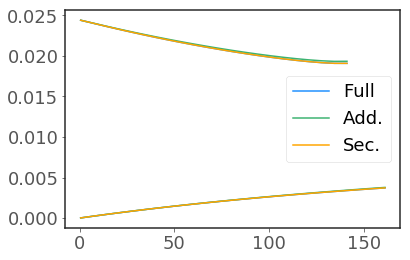

In [90]:


plot_all_four_theories(dd_4th)

In [50]:
N=7
T_ph = 300.
w_2 = 1.4*ev_to_inv_cm
bias = 10*1e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 10e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
Gamma = 100
w0 = 40e-3*ev_to_inv_cm
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                  V = V, alpha=alpha,
                  T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                  num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                  silent=True, exc_diff=0)




In [36]:
dd_4th = calculate_coherence_4_theories(PARAMS, 1, threshold=0.)

It took  64.1624219417572  seconds to build the secular RWA Liouvillian
It took  78.340815782547  seconds to build the secular RWA Liouvillian
80.905
It took  76.08886194229126  seconds to build the secular RWA Liouvillian
Calculation took 330.75743198394775 seconds
Filename: DATA/coherence/four_theories_1


In [15]:
N=8
T_ph = 300.
w_2 = 1.4*ev_to_inv_cm
bias = 10*1e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 10e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
Gamma = 100
w0 = 30e-3*ev_to_inv_cm
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                  V = V, alpha=alpha,
                  T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                  num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                  silent=True, exc_diff=0)


dd_4th = calculate_coherence_4_theories(PARAMS, 2, threshold=0.)

It took  532.894208908081  seconds to build the secular RWA Liouvillian
It took  656.7101819515228  seconds to build the secular RWA Liouvillian
80.905
It took  649.8448510169983  seconds to build the secular RWA Liouvillian
Calculation took 2290.6824209690094 seconds
Filename: DATA/coherence/four_theories_2


PLOTS/nothing.pdf


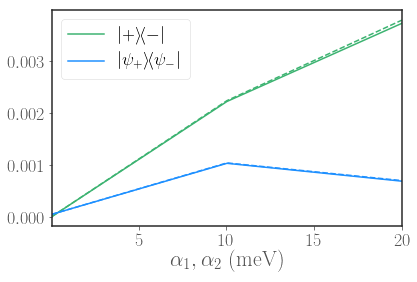

In [39]:
dd_4th = load_obj("DATA/coherence/four_theories_2")

plot_all_four_theories(dd_4th)

In [16]:
N=8
T_ph = 300.
w_2 = 1.4*ev_to_inv_cm
bias = 10*1e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 2e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
Gamma = 100
w0 = 30e-3*ev_to_inv_cm
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                  V = V, alpha=alpha,
                  T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                  num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                  silent=True, exc_diff=0)


dd_4th = calculate_coherence_4_theories(PARAMS, 3, threshold=0.)

It took  472.3839659690857  seconds to build the secular RWA Liouvillian
It took  636.2521729469299  seconds to build the secular RWA Liouvillian
80.905
It took  643.6729788780212  seconds to build the secular RWA Liouvillian
Calculation took 2288.360449075699 seconds
Filename: DATA/coherence/four_theories_3


PLOTS/nothing.pdf


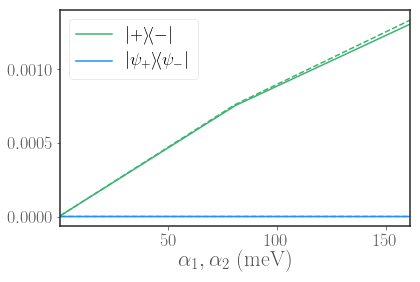

In [18]:
dd_4th = load_obj("DATA/coherence/four_theories_3")

plot_all_four_theories(dd_4th)

In [8]:
# Fig 1.13 (left)
N=6
T_ph = 300.
w_2 = 1.4*ev_to_inv_cm
bias = 15*1e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 15e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 5800.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
eta = gap(bias, V)
w0 = eta*5
wc = eta/2
Gamma = (w0**2)/wc

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                  V = V, alpha=alpha,
                  T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                  num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                  silent=True, exc_diff=0)

dd_4th = calculate_coherence_4_theories(PARAMS, 4, threshold=0.)

It took  129.90112280845642  seconds to build the secular RWA Liouvillian
It took  156.9103078842163  seconds to build the secular RWA Liouvillian
11.986428571428572
It took  154.99074482917786  seconds to build the secular RWA Liouvillian
It took  150.55770301818848  seconds to build the secular RWA Liouvillian
It took  139.30679297447205  seconds to build the secular RWA Liouvillian
It took  137.40069794654846  seconds to build the secular RWA Liouvillian
It took  135.7714810371399  seconds to build the secular RWA Liouvillian
It took  136.42936897277832  seconds to build the secular RWA Liouvillian
It took  136.57904291152954  seconds to build the secular RWA Liouvillian
It took  124.99503803253174  seconds to build the secular RWA Liouvillian
It took  136.86022996902466  seconds to build the secular RWA Liouvillian
115.36428571428573
It took  136.94985222816467  seconds to build the secular RWA Liouvillian
It took  135.9772880077362  seconds to build the secular RWA Liouvillian
It 

PLOTS/four_theories_OD.pdf


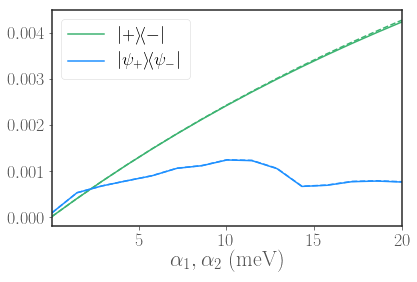

In [9]:
# Fig 1.13 (left)
dd_4th = load_obj("DATA/coherence/four_theories_4")
plot_all_four_theories(dd_4th, figname='four_theories_OD')

In [11]:
# Fig 1.13 (right)
phonons = np.array([5e-3, 15e-3, 30e-3])*ev_to_inv_cm
dd_bd = calculate_bias_dependence(phonons, PARAMS, 2, threshold=0.)
#dd_bd = load_obj("DATA/coherence/bias_2")

40.3275
40.3275
40.3275
40.3275
40.3275
40.3275
120.9825
120.9825
120.9825
120.9825
120.9825
120.9825
241.965
241.965
241.965
241.965
241.965
241.965
Calculation took 41068.925989151 seconds
Filename: DATA/coherence/bias_2


In [28]:
def plot_eig_bias_dependence(data_dict, figname=''):
    plt.figure()
    print(data_dict['PARAMS']['V'])
    #biases = 1000*data_dict['biases']/ev_to_inv_cm
    biases = data_dict['biases']/data_dict['PARAMS']['V']
    phonons = data_dict['phonons']
    i = 0
    for oplist, rho_list in zip(data_dict['op_list'], data_dict['rho_nonadd_list']):
        plt.plot(biases, np.abs(calculate_expval(rho_list, oplist,obs='eig_x')), 
                 label=r"$\alpha=$"+str(int(phonons[i]*1000/ev_to_inv_cm))+r"meV", color=colours[i], linestyle='solid')
        i+=1
    i = 0
    for oplist, rho_list in zip(data_dict['op_list'], data_dict['rho_add_list']):
        plt.plot(biases, np.abs(calculate_expval(rho_list, oplist,obs='eig_x')), color=colours[i], linestyle='dashed')
        i+=1
    plt.legend(loc='lower right')
    plt.xlim(biases[0], biases[-1])
    plt.xlabel(r'$\epsilon$ (units of $V$)')
    plt.ylabel(r'$\abs{\rho_{+-}^{ss}}$')
    name = "PLOTS/"+figname+'.pdf'
    plt.subplots_adjust(left=0.17, bottom=0.2, right=0.96, top=0.95, wspace=0.20, hspace=0.08)
    plt.savefig(name)
    print(name)

def plot_site_bias_dependence(data_dict, figname=''):
    plt.figure()
    print(data_dict['PARAMS']['V'])
    #biases = 1000*data_dict['biases']/ev_to_inv_cm
    biases = data_dict['biases']/data_dict['PARAMS']['V']
    phonons = data_dict['phonons']
    i = 0
    for oplist, rho_list in zip(data_dict['op_list'], data_dict['rho_nonadd_list']):
        plt.plot(biases, np.abs(calculate_expval(rho_list, oplist,obs='sigma_x')), 
                 label=r"$\alpha=$"+str(int(phonons[i]*1000/ev_to_inv_cm))+r"meV", color=colours[i], linestyle='solid')
        i+=1
    i = 0
    for oplist, rho_list in zip(data_dict['op_list'], data_dict['rho_add_list']):
        plt.plot(biases, np.abs(calculate_expval(rho_list, oplist,obs='sigma_x')), color=colours[i], linestyle='dashed')
        i+=1
    plt.legend(loc='upper right')
    plt.xlim(biases[0], biases[-1])
    plt.xlabel(r'$\epsilon$ (units of $V$)')
    plt.ylabel(r'$\abs{\rho_{12}^{ss}}$')
    name = "PLOTS/"+figname+'.pdf'
    plt.subplots_adjust(left=0.17, bottom=0.2, right=0.98, top=0.95, wspace=0.20, hspace=0.08)
    plt.savefig(name)
    print(name)
    
def plot_ground_bias_dependence(data_dict, figname=''):
    plt.figure()
    print(data_dict['PARAMS']['V'])
    #biases = 1000*data_dict['biases']/ev_to_inv_cm
    biases = data_dict['biases']/data_dict['PARAMS']['V']
    phonons = data_dict['phonons']
    i = 0
    for oplist, rho_list in zip(data_dict['op_list'], data_dict['rho_nonadd_list']):
        plt.plot(biases, np.abs(calculate_expval(rho_list, oplist,obs='OO')), 
                 label=r"$\alpha=$"+str(int(phonons[i]*1000/ev_to_inv_cm))+r"meV", color=colours[i], linestyle='solid')
        i+=1
    i = 0
    for oplist, rho_list in zip(data_dict['op_list'], data_dict['rho_add_list']):
        plt.plot(biases, np.abs(calculate_expval(rho_list, oplist,obs='OO')), color=colours[i], linestyle='dashed')
        i+=1
    plt.legend(loc='lower right')
    plt.xlim(biases[0], biases[-1])
    plt.xlabel(r'$\epsilon$ (units of $V$)')
    plt.ylabel(r'$\abs{\rho_{00}^{ss}}$')
    name = "PLOTS/"+figname+'.pdf'
    plt.subplots_adjust(left=0.17, bottom=0.2, right=0.98, top=0.95, wspace=0.20, hspace=0.08)
    plt.savefig(name)
    print(name)

def plot_dark_bias_dependence(data_dict, figname=''):
    plt.figure()
    print(data_dict['PARAMS']['V'])
    #biases = 1000*data_dict['biases']/ev_to_inv_cm
    biases = data_dict['biases']/data_dict['PARAMS']['V']
    phonons = data_dict['phonons']
    i = 0
    for oplist, rho_list in zip(data_dict['op_list'], data_dict['rho_nonadd_list']):
        plt.plot(biases, np.abs(calculate_expval(rho_list, oplist,obs='dark')), 
                 label=r"$\alpha=$"+str(int(phonons[i]*1000/ev_to_inv_cm))+r"meV", color=colours[i], linestyle='solid')
        i+=1
    i = 0
    for oplist, rho_list in zip(data_dict['op_list'], data_dict['rho_add_list']):
        plt.plot(biases, np.abs(calculate_expval(rho_list, oplist,obs='dark')), color=colours[i], linestyle='dashed')
        i+=1
    plt.legend(loc='lower right')
    plt.xlim(biases[0], biases[-1])
    plt.xlabel(r'$\epsilon$ (units of $V$)')
    plt.ylabel(r'$\abs{\rho_{--}^{ss}}$')
    name = "PLOTS/"+figname+'.pdf'
    plt.subplots_adjust(left=0.17, bottom=0.2, right=0.98, top=0.95, wspace=0.20, hspace=0.08)
    plt.savefig(name)
    print(name)

def plot_bright_bias_dependence(data_dict, figname=''):
    plt.figure()
    print(data_dict['PARAMS']['V'])
    #biases = 1000*data_dict['biases']/ev_to_inv_cm
    biases = data_dict['biases']/data_dict['PARAMS']['V']
    phonons = data_dict['phonons']
    i = 0
    for oplist, rho_list in zip(data_dict['op_list'], data_dict['rho_nonadd_list']):
        plt.plot(biases, np.abs(calculate_expval(rho_list, oplist,obs='bright')), 
                 label=r"$\alpha=$"+str(int(phonons[i]*1000/ev_to_inv_cm))+r"meV", color=colours[i], linestyle='solid')
        i+=1
    i = 0
    for oplist, rho_list in zip(data_dict['op_list'], data_dict['rho_add_list']):
        plt.plot(biases, np.abs(calculate_expval(rho_list, oplist,obs='bright')), color=colours[i], linestyle='dashed')
        i+=1
    plt.legend(loc='lower right')
    plt.xlim(biases[0], biases[-1])
    plt.xlabel(r'$\epsilon$ (units of $V$)')
    plt.ylabel(r'$\abs{\rho_{++}^{ss}}$')
    name = "PLOTS/"+figname+'.pdf'
    plt.subplots_adjust(left=0.17, bottom=0.2, right=0.98, top=0.95, wspace=0.20, hspace=0.08)
    plt.savefig(name)
    print(name)

120.9825
PLOTS/PAPER/bias-dependence-OD-eig.pdf
120.9825
PLOTS/PAPER/bias-dependence-OD-site.pdf
120.9825
PLOTS/PAPER/bias-dependence-OD-ground.pdf
120.9825
PLOTS/PAPER/bias-dependence-OD-dark.pdf
120.9825
PLOTS/PAPER/bias-dependence-OD-bright.pdf


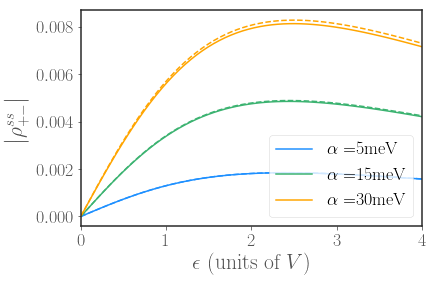

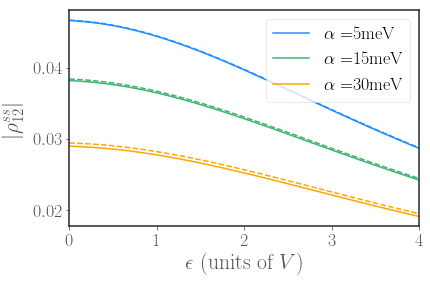

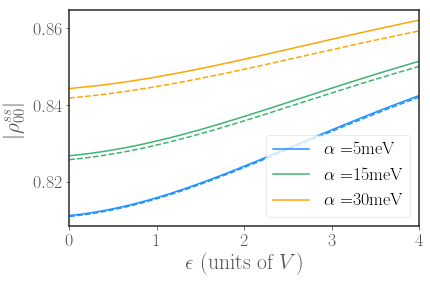

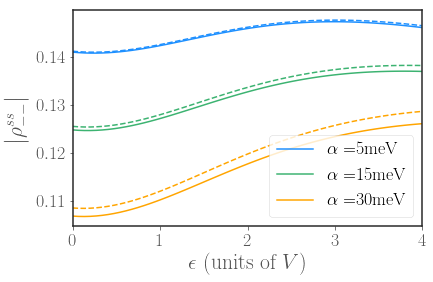

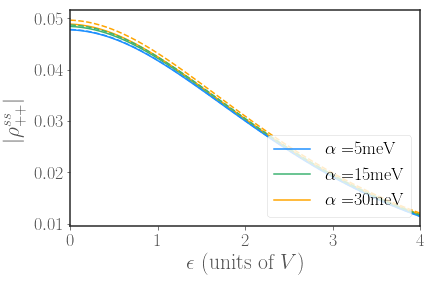

In [29]:
# Fig 1.13 (right)
plot_eig_bias_dependence(dd_bd, "PAPER/bias-dependence-OD-eig")
plot_site_bias_dependence(dd_bd, "PAPER/bias-dependence-OD-site")
plot_ground_bias_dependence(dd_bd, "PAPER/bias-dependence-OD-ground")
plot_dark_bias_dependence(dd_bd, "PAPER/bias-dependence-OD-dark")
plot_bright_bias_dependence(dd_bd, "PAPER/bias-dependence-OD-bright")

In [29]:
dd_bd = load_obj("DATA/coherence/bias_OD")

In [6]:
# OD (14/08/2019) Ruhn with N=5, num_biases = 60
N=2
T_ph = 300.
w_2 = 1.4*ev_to_inv_cm
bias = 15*1e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 15e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3

eta = gap(bias, V)
wc = eta
w0 = 5*eta #40e-3*ev_to_inv_cm
Gamma = (w0**2)/wc

phonons = np.array([5,15,30])*1e-3*ev_to_inv_cm

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                  V = V, alpha=alpha,
                  T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                  num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                  silent=True, exc_diff=0)

dd_bd_OD = calculate_bias_dependence_CC(phonons, PARAMS, 'OD-3', threshold=0., num_biases=4)

40.3275
120.9825
241.965
Calculation took 10.746318817138672 seconds
Filename: DATA/coherence/bias_OD-3


120.9825
PLOTS/BD-OD.pdf
120.9825
PLOTS/BD-OD.pdf
120.9825
PLOTS/BD-OD.pdf


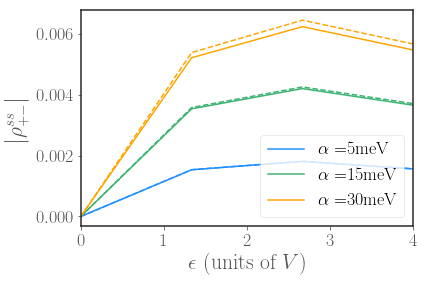

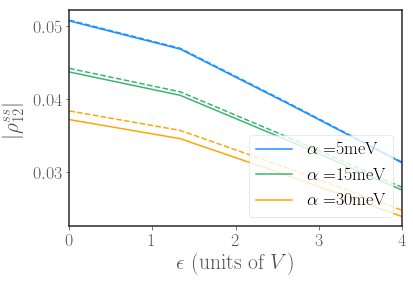

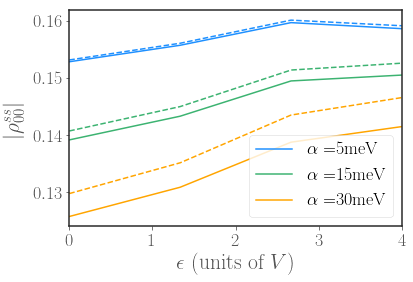

In [13]:
plot_eig_bias_dependence(dd_bd_OD, figname='BD-OD')
plot_site_bias_dependence(dd_bd_OD, figname='BD-OD')
plot_ground_bias_dependence(dd_bd_OD, figname='BD-OD')